# setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta, date
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta, date
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm

In [2]:
from vnstock import Listing, Quote, Company, Finance, Trading, Screener 

/opt/conda/envs/quant/lib/python3.12/site-packages/vnai/scope/profile.py:562: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


# load data

In [3]:
def get_symbols_by_group(group_name):
    listing = Listing()
    return listing.symbols_by_group(group_name)

def fetch_history_for_symbols(symbols, start='2010-01-01', end='2025-08-25', interval='1D'):
    all_data = []
    for symbol in symbols:
        quote = Quote(symbol=symbol, source='VCI')
        df = quote.history(start=start, end=end, interval=interval)
        df['symbol'] = symbol
        all_data.append(df)
    result = pd.concat(all_data, ignore_index=True)
    result['time'] = pd.to_datetime(result['time'])
    return result

def save_to_csv(df, filepath):
    df.to_csv(filepath, index=False)
    print(f"Đã lưu dữ liệu vào {filepath}")

def filter_data_by_symbol(symbol, df, start=None, end=None):
    df.index = pd.to_datetime(df.index)
    if start is None:
        start = df.index.min()
    if end is None:
        end = df.index.max()
    return df[(df['symbol'] == symbol) & (df.index >= start) & (df.index <= end)]

In [4]:
# Fetch VN30F1M (nearest month VN30 futures) historical data using vnstock
vn30f1m_quote = Quote(symbol='VN30F1M', source='VCI')
vn30f1m_index = vn30f1m_quote.history(start='2018-01-01', end='2025-08-25', interval='1D')
vn30f1m_index['time'] = pd.to_datetime(vn30f1m_index['time'])
vn30f1m_index = vn30f1m_index.set_index('time')
vn30f1m_index.head()

,open,high,low,close,volume
time,,,,,
2018-01-02,983.9,999.0,980.8,999.0,11347
2018-01-03,1002.5,1015.2,1002.0,1012.8,16134
2018-01-04,1014.8,1023.9,1012.8,1023.9,13815
2018-01-05,1024.1,1025.0,1007.0,1012.0,16296
2018-01-08,1008.3,1031.0,1005.7,1030.0,13326


In [5]:
# Fetch VN30 index historical data using vnstock
vn30_quote = Quote(symbol='VN30', source='VCI')
vn30_index = vn30_quote.history(start='2010-01-01', end='2025-08-25', interval='1D')
vn30_index['time'] = pd.to_datetime(vn30_index['time'])
vn30_index = vn30_index.set_index('time')
vn30_index.head()

,open,high,low,close,volume
time,,,,,
2012-02-06,447.47,447.47,447.47,447.47,13467070
2012-02-07,449.31,449.31,449.31,449.31,17261070
2012-02-08,460.98,460.98,460.98,460.98,20406280
2012-02-09,464.73,464.73,464.73,464.73,20379320
2012-02-10,458.23,458.23,458.23,458.23,20816360


In [6]:
data_all = pd.read_csv('data/vn30_history.csv')
data_all = data_all.set_index('time')
data_all.head()

,open,high,low,close,volume,symbol
time,,,,,,
2010-01-04,3.71,3.97,3.69,3.97,2765900,ACB
2010-01-05,4.06,4.14,3.94,3.97,1929200,ACB
2010-01-06,3.96,4.01,3.86,3.86,1303300,ACB
2010-01-07,3.95,3.97,3.84,3.86,1342000,ACB
2010-01-08,3.87,4.01,3.80,3.83,1461300,ACB


In [7]:
df_hpg = filter_data_by_symbol('HPG',df=data_all)
df_hpg.head()

,open,high,low,close,volume,symbol
time,,,,,,
2010-01-04,1.47,1.49,1.47,1.49,603120,HPG
2010-01-05,1.56,1.56,1.49,1.56,1203080,HPG
2010-01-06,1.55,1.61,1.54,1.61,1771660,HPG
2010-01-07,1.64,1.68,1.61,1.66,1535800,HPG
2010-01-08,1.70,1.70,1.59,1.59,909010,HPG


# macd divergence

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---------- EMA & MACD ----------
def ema_tv(series: pd.Series, length: int) -> pd.Series:
    s = pd.Series(series, dtype='float64').copy()
    if s.first_valid_index() is None:
        return pd.Series(np.nan, index=s.index)
    alpha = 2.0 / (length + 1.0)
    ema = np.full(len(s), np.nan)
    i0 = np.where(~np.isnan(s.values))[0][0]
    ema[i0] = s.iloc[i0]
    for i in range(i0 + 1, len(s)):
        ema[i] = alpha * s.iloc[i] + (1 - alpha) * ema[i - 1]
    return pd.Series(ema, index=s.index)

def calculate_macd(series: pd.Series, fast=12, slow=26, signal=9):
    ema_fast = ema_tv(series, fast)
    ema_slow = ema_tv(series, slow)
    macd = ema_fast - ema_slow
    macd_signal = ema_tv(macd, signal)
    hist = macd - macd_signal
    return macd, macd_signal, hist

# ---------- Extrema Finder ----------
def find_hist_extrema(hist: pd.Series, strict_window=5, local_window=1):
    s = pd.Series(hist, dtype='float64').copy()
    peaks_strict, troughs_strict = [], []
    peaks_local, troughs_local = [], []

    for i in range(len(s)):
        # strict extrema (t1/p1) = 5 nến trước + 5 nến sau
        if i >= strict_window and i < len(s) - strict_window:
            window = s.iloc[i - strict_window:i + strict_window + 1]
            if s.iloc[i] == window.max() and s.iloc[i] > 0:
                peaks_strict.append(s.index[i])
            if s.iloc[i] == window.min() and s.iloc[i] < 0:
                troughs_strict.append(s.index[i])

        # local extrema (t2/p2) = 1 nến trước + 1 nến sau
        if i >= local_window and i < len(s) - local_window:
            window = s.iloc[i - local_window:i + local_window + 1]
            if s.iloc[i] == window.max() and s.iloc[i] > 0:
                peaks_local.append(s.index[i])
            if s.iloc[i] == window.min() and s.iloc[i] < 0:
                troughs_local.append(s.index[i])

    return {
        "peaks_strict": peaks_strict,
        "troughs_strict": troughs_strict,
        "peaks_local": peaks_local,
        "troughs_local": troughs_local
    }

# ---------- Divergence Finder ----------
def find_macd_divergence(df, fast=12, slow=26, signal=9, window_min = 15, window=45):
    df = df.sort_index().copy()
    df['macd'], df['signal'], df['hist'] = calculate_macd(df['close'], fast, slow, signal)

    hist_ext = find_hist_extrema(df['hist'])
    bullish, bearish = [], []

    # bullish divergence: t1 strict, t2 local
    for t1 in hist_ext["troughs_strict"]:
        for t2 in hist_ext["troughs_local"]:
            if t2 <= t1: 
                continue
            if (t2 - t1).days > window: 
                continue
            if (t2 - t1).days < window_min:
                continue
            # boolean mask để lấy hist giữa t1 và t2
            mask = (df.index > t1) & (df.index < t2)
            if not mask.any():  # nếu không có cây nào giữa
                continue
            if (df.loc[mask, 'hist'] > 0).any():  # ít nhất 1 cây > 0 (cross above zero, per Elder)
                if df.loc[t2, 'close'] < df.loc[t1, 'close'] and df.loc[t2, 'hist'] > df.loc[t1, 'hist']:
                    bullish.append((t1, t2))

    # bearish divergence: p1 strict, p2 local
    for p1 in hist_ext["peaks_strict"]:
        for p2 in hist_ext["peaks_local"]:
            if p2 <= p1: 
                continue
            if (p2 - p1).days > window: 
                continue
            if (p2 - p1).days < window_min: 
                continue
            mask = (df.index > p1) & (df.index < p2)
            if not mask.any():
                continue
            if (df.loc[mask, 'hist'] < 0).any():  # ít nhất 1 cây < 0 (cross below zero, per Elder)
                if df.loc[p2, 'close'] > df.loc[p1, 'close'] and df.loc[p2, 'hist'] < df.loc[p1, 'hist']:
                    bearish.append((p1, p2))


    bull_df = pd.DataFrame(bullish, columns=['t1','t2']).set_index('t2') if bullish else pd.DataFrame(columns=['t1'])
    bear_df = pd.DataFrame(bearish, columns=['p1','p2']).set_index('p2') if bearish else pd.DataFrame(columns=['p1'])
    def remove_dup(df):
      df = df[~df.index.duplicated(keep='first')]
      return df
    bull_df = remove_dup(bull_df)
    bear_df = remove_dup(bear_df)

    return bull_df, bear_df, df, hist_ext

# ---------- Visualization ----------
def visualize_divergence(df, bullish, bearish, hist_ext, annotate=True):
    fig, (ax1, ax2) = plt.subplots(2,1, figsize=(14,10), sharex=True,
                                   gridspec_kw={'height_ratios':[2,1]})

    ax1.plot(df.index, df['close'], label='Close', color='black')
    ax2.bar(df.index, df['hist'], alpha=0.5, label='Histogram')
    ax2.plot(df.index, df['macd'], label='MACD')
    ax2.plot(df.index, df['signal'], label='Signal', linestyle='--')
    ax2.axhline(0, color='black', lw=0.7)

    # mark extrema
    ax2.scatter(hist_ext["peaks_strict"], df.loc[hist_ext["peaks_strict"], 'hist'], marker='^', color='red', s=80, label='Peak strict')
    ax2.scatter(hist_ext["troughs_strict"], df.loc[hist_ext["troughs_strict"], 'hist'], marker='v', color='green', s=80, label='Trough strict')
    ax2.scatter(hist_ext["peaks_local"], df.loc[hist_ext["peaks_local"], 'hist'], marker='^', color='orange', s=60, label='Peak local')
    ax2.scatter(hist_ext["troughs_local"], df.loc[hist_ext["troughs_local"], 'hist'], marker='v', color='blue', s=60, label='Trough local')

    # bullish
    for t2, row in bullish.iterrows():
        t1 = row['t1']
        ax1.plot([t1,t2], [df.loc[t1,'close'], df.loc[t2,'close']], color='green', lw=2)
        ax2.plot([t1,t2], [df.loc[t1,'hist'], df.loc[t2,'hist']], color='green', lw=2)
        if annotate: ax1.text(t2, df.loc[t2,'close'], 'Bull', color='green')

    # bearish
    for p2, row in bearish.iterrows():
        p1 = row['p1']
        ax1.plot([p1,p2], [df.loc[p1,'close'], df.loc[p2,'close']], color='red', lw=2)
        ax2.plot([p1,p2], [df.loc[p1,'hist'], df.loc[p2,'hist']], color='red', lw=2)
        if annotate: ax1.text(p2, df.loc[p2,'close'], 'Bear', color='red')

    ax1.legend()
    ax2.legend()
    plt.tight_layout()
    return fig, ax1, ax2



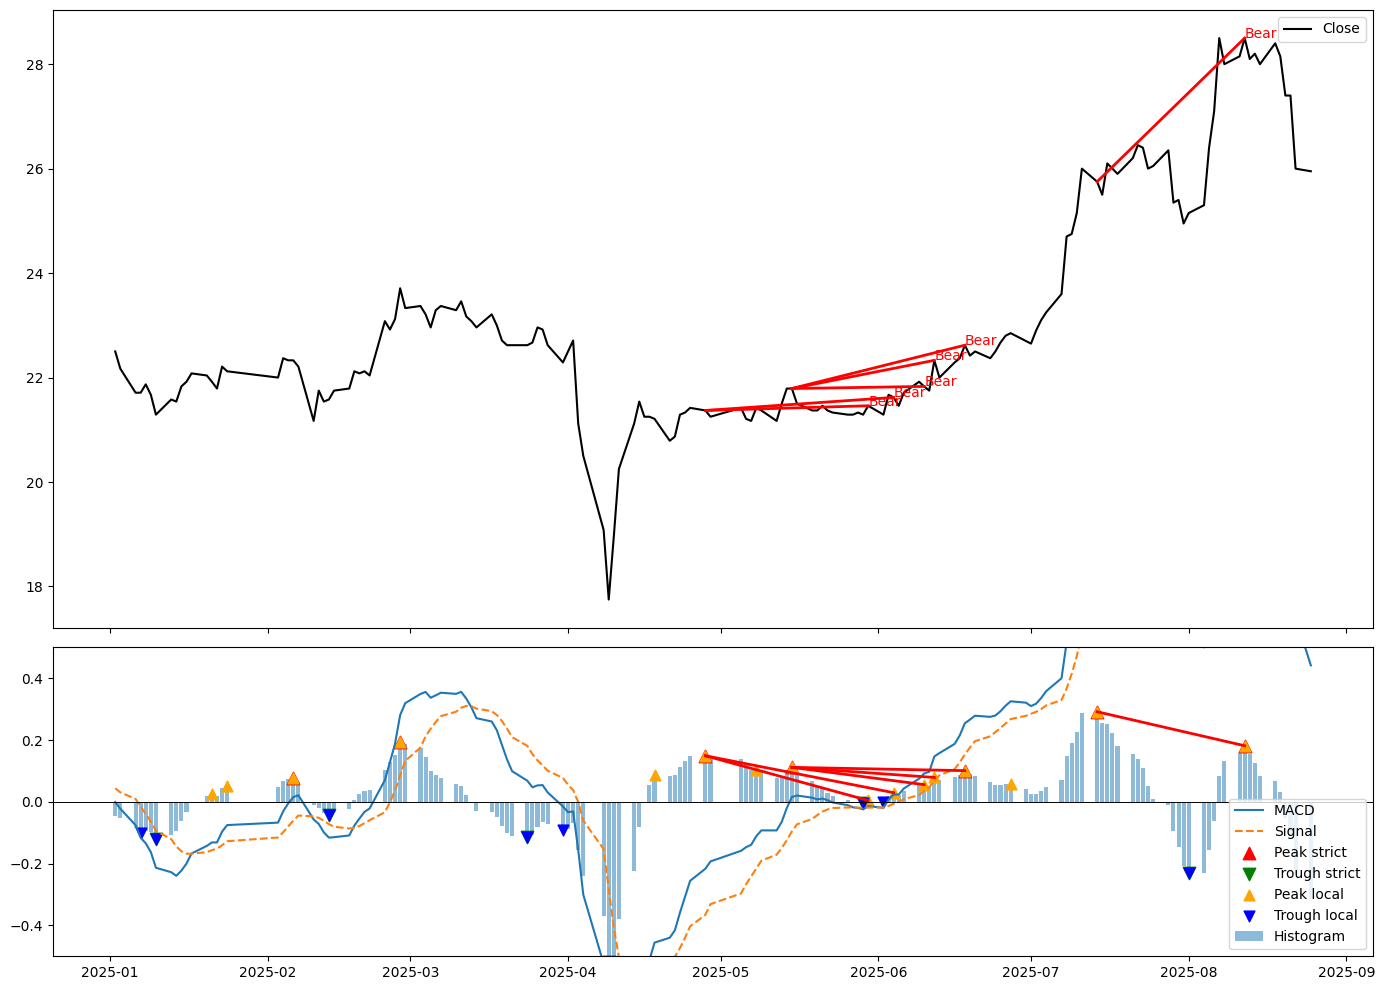

In [13]:

# ...existing code...
start_date = "2025-01-01"
end_date = "2025-08-26"

bullish, bearish, df_res, hist_ext = find_macd_divergence(df_hpg, window=40)
# remove duplicate
bullish = bullish[~bullish.index.duplicated(keep='first')]
bearish = bearish[~bearish.index.duplicated(keep='first')]

df_res_filtered = df_res.loc[start_date:end_date]

# Lọc bullish: cả index (t2) và t1 đều nằm trong df_res_filtered.index
bullish_filtered = bullish[
    (bullish.index >= start_date) & (bullish.index <= end_date) &
    (bullish['t1'] >= df_res_filtered.index.min()) & (bullish['t1'] <= df_res_filtered.index.max())
]

# Lọc bearish: cả index (p2) và p1 đều nằm trong df_res_filtered.index
bearish_filtered = bearish[
    (bearish.index >= start_date) & (bearish.index <= end_date) &
    (bearish['p1'] >= df_res_filtered.index.min()) & (bearish['p1'] <= df_res_filtered.index.max())
]

# ...existing code...
# Lọc hist_ext để chỉ giữ các timestamp còn trong df_res_filtered
def filter_hist_ext(hist_ext, valid_index):
    return {
        k: [x for x in v if x in valid_index]
        for k, v in hist_ext.items()
    }

hist_ext_filtered = filter_hist_ext(hist_ext, df_res_filtered.index)

fig, ax1, ax2 = visualize_divergence(df_res_filtered, bullish_filtered, bearish_filtered, hist_ext_filtered)

# ax1.set_ylim(23, 30)
ax2.set_ylim(-0.5, 0.5)

plt.show()

# stats

In [14]:
num_bullish = bullish.index.unique().size
num_bearish = bearish.index.unique().size

print(f"Số tín hiệu bullish (unique): {num_bullish}")
print(f"Số tín hiệu bearish (unique): {num_bearish}")

Số tín hiệu bullish (unique): 27
Số tín hiệu bearish (unique): 57


In [16]:
import numpy as np
import pandas as pd

def analyze_price_action_after_signal(df, signal_dates, window=20):
    """
    Phân tích hành động giá sau tín hiệu.

    Parameters:
    df (pd.DataFrame): DataFrame chứa dữ liệu giá, phải có cột 'close' và 'high', 'low'.
    signal_dates (pd.DatetimeIndex): Danh sách các ngày có tín hiệu (index của bullish/bearish).
    window (int): Số ngày giao dịch sau tín hiệu để phân tích.

    Returns:
    pd.DataFrame: DataFrame chứa kết quả phân tích cho từng tín hiệu.
    """
    results = []

    for signal_date in signal_dates:
        # Kiểm tra ngày tín hiệu có trong dữ liệu không
        if signal_date not in df.index:
            continue

        # Lấy giá tại thời điểm tín hiệu
        signal_price = df.loc[signal_date, 'close']

        # Xác định cửa sổ 20 ngày sau tín hiệu (không bao gồm ngày tín hiệu)
        start_idx = df.index.get_loc(signal_date) + 1
        end_idx = start_idx + window

        # Kiểm tra xem có đủ 20 ngày dữ liệu phía sau không
        if end_idx > len(df):
            # Nếu không đủ, phân tích đến cuối dataset
            future_data = df.iloc[start_idx:]
        else:
            future_data = df.iloc[start_idx:end_idx]

        if len(future_data) == 0:
            continue

        # Tìm giá cao nhất và thấp nhất trong 20 ngày tiếp theo
        highest_price = future_data['high'].max()
        lowest_price = future_data['low'].min()

        # Tìm thời điểm xảy ra giá cao nhất và thấp nhất
        highest_date = future_data['high'].idxmax()
        lowest_date = future_data['low'].idxmin()

        # Tính phần trăm thay đổi so với giá tại tín hiệu
        pct_to_high = ((highest_price - signal_price) / signal_price) * 100
        pct_to_low = ((lowest_price - signal_price) / signal_price) * 100

        # Xác định sự kiện nào xảy ra trước: đỉnh hay đáy
        if highest_date < lowest_date:
            first_event = 'peak_first'
        elif lowest_date < highest_date:
            first_event = 'trough_first'
        else:
            first_event = 'same_day'

        # Lưu kết quả
        results.append({
            'signal_date': signal_date,
            'signal_price': signal_price,
            'highest_price': highest_price,
            'lowest_price': lowest_price,
            'highest_date': highest_date,
            'lowest_date': lowest_date,
            'pct_to_high': pct_to_high,
            'pct_to_low': pct_to_low,
            'first_event': first_event,
            'days_analyzed': len(future_data)
        })

    return pd.DataFrame(results)

# --- SỬ DỤNG HÀM ---
# Giả sử bạn đã có:
# bullish_signals, bearish_signals từ hàm find_macd_divergence
# df_hpg: DataFrame chứa giá HPG, có các cột 'close', 'high', 'low'

# Phân tích cho tín hiệu BULLISH
bullish_analysis_df = analyze_price_action_after_signal(
    df=df_hpg,
    signal_dates=bullish.index,  # Các ngày t2
    window=20
)

# Phân tích cho tín hiệu BEARISH
bearish_analysis_df = analyze_price_action_after_signal(
    df=df_hpg,
    signal_dates=bearish.index,  # Các ngày p2
    window=20
)

# --- HIỂN THỊ KẾT QUẢ TỔNG QUAN ---
print("==============================================")
print("PHÂN TÍCH BIÊN ĐỘ GIÁ 20 NGÀY SAU TÍN HIỆU")
print("==============================================")

if not bullish_analysis_df.empty:
    print(f"\n--- KẾT QUẢ CHO {len(bullish_analysis_df)} TÍN HIỆU BULLISH ---")
    print(f"Giá tăng cao nhất trung bình: {bullish_analysis_df['pct_to_high'].mean():.2f}%")
    print(f"Giá tăng cao nhất phân vị 25/50/75: {bullish_analysis_df['pct_to_high'].quantile(0.25):.2f}% / {bullish_analysis_df['pct_to_high'].quantile(0.5):.2f}% / {bullish_analysis_df['pct_to_high'].quantile(0.75):.2f}%")
    print(f"Giá giảm thấp nhất trung bình: {bullish_analysis_df['pct_to_low'].mean():.2f}%")
    print(f"Giá giảm thấp nhất phân vị 25/50/75: {bullish_analysis_df['pct_to_low'].quantile(0.25):.2f}% / {bullish_analysis_df['pct_to_low'].quantile(0.5):.2f}% / {bullish_analysis_df['pct_to_low'].quantile(0.75):.2f}%")
    print(f"Biên độ dao động trung bình: {bullish_analysis_df['pct_to_high'].mean() - bullish_analysis_df['pct_to_low'].mean():.2f}%")
    
    # Thống kê sự kiện nào xảy ra trước
    first_event_counts = bullish_analysis_df['first_event'].value_counts()
    print("\nSự kiện xảy ra trước:")
    for event, count in first_event_counts.items():
        pct = (count / len(bullish_analysis_df)) * 100
        print(f"  {event}: {count} lần ({pct:.1f}%)")

if not bearish_analysis_df.empty:
    print(f"\n--- KẾT QUẢ CHO {len(bearish_analysis_df)} TÍN HIỆU BEARISH ---")
    print(f"Giá tăng cao nhất trung bình: {bearish_analysis_df['pct_to_high'].mean():.2f}%")
    print(f"Giá giảm thấp nhất trung bình: {bearish_analysis_df['pct_to_low'].mean():.2f}%")
    print(f"Biên độ dao động trung bình: {bearish_analysis_df['pct_to_high'].mean() - bearish_analysis_df['pct_to_low'].mean():.2f}%")

    # Thống kê sự kiện nào xảy ra trước
    first_event_counts = bearish_analysis_df['first_event'].value_counts()
    print("\nSự kiện xảy ra trước:")
    for event, count in first_event_counts.items():
        pct = (count / len(bearish_analysis_df)) * 100
        print(f"  {event}: {count} lần ({pct:.1f}%)")

# --- HIỂN THỊ KẾT QUẢ CHI TIẾT CHO TỪNG TÍN HIỆU ---
print(f"\n--- CHI TIẾT 5 TÍN HIỆU BULLISH ĐẦU TIÊN ---")
print(bullish_analysis_df[['signal_date', 'pct_to_high', 'pct_to_low', 'first_event']].head().to_string())

print(f"\n--- CHI TIẾT 5 TÍN HIỆU BEARISH ĐẦU TIÊN ---")
print(bearish_analysis_df[['signal_date', 'pct_to_high', 'pct_to_low', 'first_event']].head().to_string())

# --- PHÂN TÍCH BỔ SUNG: TẦN SUẤT CÁC MỨC BIÊN ĐỘ ---
def analyze_price_extremes(analysis_df, signal_type):
    """Phân tích các mức biên độ giá cực đoan"""
    if analysis_df.empty:
        return
    
    print(f"\n--- PHÂN TÍCH MỨC ĐỘ CỰC ĐOAN CHO {signal_type} ---")
    
    # Phần trăm tăng cao nhất
    print("Mức tăng cao nhất đạt được:")
    print(f"  Trên 20%: {(analysis_df['pct_to_high'] > 20).sum()} tín hiệu")
    print(f"  Trên 10%: {(analysis_df['pct_to_high'] > 10).sum()} tín hiệu")
    print(f"  Trên 5%: {(analysis_df['pct_to_high'] > 5).sum()} tín hiệu")
    print(f"  Dưới 0%: {(analysis_df['pct_to_high'] < 0).sum()} tín hiệu")
    
    # Phần trăm giảm thấp nhất
    print("\nMức giảm thấp nhất:")
    print(f"  Dưới -20%: {(analysis_df['pct_to_low'] < -20).sum()} tín hiệu")
    print(f"  Dưới -10%: {(analysis_df['pct_to_low'] < -10).sum()} tín hiệu")
    print(f"  Dưới -5%: {(analysis_df['pct_to_low'] < -5).sum()} tín hiệu")
    print(f"  Trên 0%: {(analysis_df['pct_to_low'] > 0).sum()} tín hiệu")

# Áp dụng phân tích bổ sung
analyze_price_extremes(bullish_analysis_df, "BULLISH")
analyze_price_extremes(bearish_analysis_df, "BEARISH")

PHÂN TÍCH BIÊN ĐỘ GIÁ 20 NGÀY SAU TÍN HIỆU

--- KẾT QUẢ CHO 27 TÍN HIỆU BULLISH ---
Giá tăng cao nhất trung bình: 12.79%
Giá tăng cao nhất phân vị 25/50/75: 5.12% / 8.02% / 16.85%
Giá giảm thấp nhất trung bình: -8.58%
Giá giảm thấp nhất phân vị 25/50/75: -14.49% / -5.82% / -1.23%
Biên độ dao động trung bình: 21.36%

Sự kiện xảy ra trước:
  trough_first: 15 lần (55.6%)
  peak_first: 12 lần (44.4%)

--- KẾT QUẢ CHO 57 TÍN HIỆU BEARISH ---
Giá tăng cao nhất trung bình: 9.34%
Giá giảm thấp nhất trung bình: -5.52%
Biên độ dao động trung bình: 14.86%

Sự kiện xảy ra trước:
  trough_first: 37 lần (64.9%)
  peak_first: 20 lần (35.1%)

--- CHI TIẾT 5 TÍN HIỆU BULLISH ĐẦU TIÊN ---
  signal_date  pct_to_high  pct_to_low   first_event
0  2010-08-12    25.409836   -3.278689  trough_first
1  2012-07-11     5.208333   -1.041667    peak_first
2  2014-10-27     9.593023   -0.872093  trough_first
3  2014-12-11     4.692082  -11.730205  trough_first
4  2015-12-10     5.460751   -6.484642    peak_first

-

# backtest

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def backtest_divergence_strategy(df, bullish_signals, initial_capital=100000000, stop_loss_pct=-0.10, take_profit_pct=0.20, max_hold_days=40):
    """
    Backtest chiến lược giao dịch divergence.

    Parameters:
    df (pd.DataFrame): DataFrame chứa dữ liệu giá, có cột 'close'.
    bullish_signals (pd.DataFrame): DataFrame chứa các tín hiệu bullish.
    initial_capital (float): Vốn ban đầu.
    stop_loss_pct (float): % cắt lỗ (ví dụ: -0.10 cho -10%).
    take_profit_pct (float): % chốt lời (ví dụ: 0.20 cho +20%).
    max_hold_days (int): Số ngày tối đa nắm giữ.

    Returns:
    pd.DataFrame: Kết quả chi tiết của từng lệnh.
    pd.Series: Equity curve.
    dict: Các số liệu tổng quan.
    """
    # Tạo bản sao để tránh thay đổi dữ liệu gốc
    df = df.copy()
    signals = bullish_signals.copy()
    
    # Khởi tạo biến
    capital = initial_capital
    position = None
    entry_price = 0
    entry_date = None
    trade_results = []
    equity_curve = []
    
    # Tạo cột để theo dõi trạng thái
    df['equity'] = np.nan
    df['signal'] = 0  # 0: No signal, 1: Buy signal
    
    # Đánh dấu các ngày có tín hiệu vào lệnh (ngày sau tín hiệu)
    for signal_date in signals.index:
        signal_idx = df.index.get_loc(signal_date)
        if signal_idx + 1 < len(df):
            entry_candidate_date = df.index[signal_idx + 1]
            df.loc[entry_candidate_date, 'signal'] = 1
    
    # Vòng lặp backtest chính
    for i, current_date in enumerate(df.index):
        current_price = df.loc[current_date, 'close']
        current_equity = capital
        
        # Nếu đang nắm giữ lệnh
        if position == 'long':
            days_in_trade = (current_date - entry_date).days
            # Tính lợi nhuận hiện tại
            current_pnl_pct = (current_price - entry_price) / entry_price
            current_value = capital * (1 + current_pnl_pct)
            
            # Kiểm tra điều kiện thoát lệnh
            exit_reason = None
            exit_price = current_price
            
            # Điều kiện CẮT LỖ
            if current_pnl_pct <= stop_loss_pct:
                exit_reason = 'STOP_LOSS'
                capital = capital * (1 + stop_loss_pct)
            # Điều kiện CHỐT LỜI
            elif current_pnl_pct >= take_profit_pct:
                exit_reason = 'TAKE_PROFIT'
                capital = capital * (1 + take_profit_pct)
            # Điều kiện HẾT THỜI GIAN
            elif days_in_trade >= max_hold_days:
                exit_reason = 'MAX_HOLD_DAYS'
                capital = current_value  # Thoát ở giá hiện tại
            
            # Nếu thoát lệnh, ghi lại kết quả
            if exit_reason:
                trade_results.append({
                    'entry_date': entry_date,
                    'exit_date': current_date,
                    'entry_price': entry_price,
                    'exit_price': exit_price,
                    'exit_reason': exit_reason,
                    'hold_days': days_in_trade,
                    'pnl_pct': (capital - current_equity) / current_equity if exit_reason != 'STOP_LOSS' else stop_loss_pct,
                    'capital_after_trade': capital
                })
                position = None
                entry_date = None
                current_equity = capital
        
        # Nếu không nắm giữ lệnh và có tín hiệu mua
        if position is None and df.loc[current_date, 'signal'] == 1:
            position = 'long'
            entry_price = current_price
            entry_date = current_date
            # Ghi nhận vốn tại thời điểm vào lệnh
            current_equity = capital
        
        # Ghi lại đường vốn
        df.loc[current_date, 'equity'] = current_equity
    
    # Tạo DataFrame kết quả
    results_df = pd.DataFrame(trade_results)
    
    # Tính các số liệu tổng quan
    if not results_df.empty:
        total_trades = len(results_df)
        winning_trades = len(results_df[results_df['pnl_pct'] > 0])
        losing_trades = len(results_df[results_df['pnl_pct'] < 0])
        win_rate = winning_trades / total_trades * 100
        
        avg_profit = results_df['pnl_pct'].mean() * 100
        max_profit = results_df['pnl_pct'].max() * 100
        max_loss = results_df['pnl_pct'].min() * 100
        
        profit_factor = abs(results_df[results_df['pnl_pct'] > 0]['pnl_pct'].sum() / 
                           results_df[results_df['pnl_pct'] < 0]['pnl_pct'].sum()) if losing_trades > 0 else float('inf')
        
        final_capital = capital
        total_return_pct = (final_capital - initial_capital) / initial_capital * 100
        
        metrics = {
            'total_trades': total_trades,
            'winning_trades': winning_trades,
            'losing_trades': losing_trades,
            'win_rate': win_rate,
            'avg_profit_pct': avg_profit,
            'max_profit_pct': max_profit,
            'max_loss_pct': max_loss,
            'profit_factor': profit_factor,
            'final_capital': final_capital,
            'total_return_pct': total_return_pct,
            'initial_capital': initial_capital
        }
    else:
        metrics = {}
        results_df = pd.DataFrame()
    
    return results_df, df['equity'].ffill(), metrics

def analyze_backtest_results(results_df, equity_curve, metrics):
    """Phân tích và hiển thị kết quả backtest"""
    print("==============================================")
    print("KẾT QUẢ BACKTEST CHIẾN LƯỢC DIVERGENCE")
    print("==============================================")
    
    if results_df.empty:
        print("Không có giao dịch nào được thực hiện.")
        return
    
    print(f"\n--- SỐ LIỆU TỔNG QUAN ---")
    print(f"Tổng số lệnh: {metrics['total_trades']}")
    print(f"Số lệnh thắng: {metrics['winning_trades']}")
    print(f"Số lệnh thua: {metrics['losing_trades']}")
    print(f"Tỷ lệ thắng: {metrics['win_rate']:.2f}%")
    print(f"Lợi nhuận trung bình/lệnh: {metrics['avg_profit_pct']:.2f}%")
    print(f"Lợi nhuận tốt nhất: {metrics['max_profit_pct']:.2f}%")
    print(f"Thua lỗ nhất: {metrics['max_loss_pct']:.2f}%")
    print(f"Profit Factor: {metrics['profit_factor']:.2f}")
    print(f"Vốn ban đầu: {metrics['initial_capital']:,.0f} VNĐ")
    print(f"Vốn cuối cùng: {metrics['final_capital']:,.0f} VNĐ")
    print(f"Tổng lợi nhuận: {metrics['total_return_pct']:.2f}%")
    
    print(f"\n--- PHÂN TÍCH THEO NGUYÊN NHÂN THOÁT LỆNH ---")
    exit_reason_stats = results_df.groupby('exit_reason').agg({
        'pnl_pct': ['count', 'mean', 'min', 'max']
    }).round(4) * 100
    print(exit_reason_stats)
    
    print(f"\n--- 5 LỆNH TỐT NHẤT ---")
    best_trades = results_df.nlargest(5, 'pnl_pct')[['entry_date', 'exit_date', 'hold_days', 'pnl_pct', 'exit_reason']]
    best_trades['pnl_pct'] = best_trades['pnl_pct'] * 100
    print(best_trades.to_string())
    
    print(f"\n--- 5 LỆNH TỆ NHẤT ---")
    worst_trades = results_df.nsmallest(5, 'pnl_pct')[['entry_date', 'exit_date', 'hold_days', 'pnl_pct', 'exit_reason']]
    worst_trades['pnl_pct'] = worst_trades['pnl_pct'] * 100
    print(worst_trades.to_string())
    
    # Vẽ biểu đồ đường vốn
    plt.figure(figsize=(12, 6))
    plt.plot(equity_curve.index, equity_curve.values / metrics['initial_capital'] * 100)
    plt.title('Đường vốn (Equity Curve) - Base 100')
    plt.ylabel('Vốn (%)')
    plt.xlabel('Thời gian')
    plt.grid(True)
    plt.show()
    
    # Vẽ biểu đồ phân bố lợi nhuận
    plt.figure(figsize=(10, 6))
    plt.hist(results_df['pnl_pct'] * 100, bins=20, alpha=0.7, edgecolor='black')
    plt.axvline(x=0, color='red', linestyle='--', label='Break-even')
    plt.axvline(x=metrics['avg_profit_pct'], color='green', linestyle='--', label=f'Trung bình: {metrics["avg_profit_pct"]:.2f}%')
    plt.title('Phân bố lợi nhuận các lệnh')
    plt.xlabel('Lợi nhuận (%)')
    plt.ylabel('Số lệnh')
    plt.legend()
    plt.grid(True)
    plt.show()

In [26]:
def run_macd_backtest_for_symbol(symbol, data_all=data_all, window=40, initial_capital=100_000_000, stop_loss_pct=-0.10, take_profit_pct=0.30, max_hold_days=90):
    """
    Chạy toàn bộ quy trình MACD divergence + backtest cho 1 mã cổ phiếu.
    """
    # Lọc dữ liệu cho symbol
    df_symbol = filter_data_by_symbol(symbol, data_all)
    # Tìm divergence
    bullish, bearish, df_res, hist_ext = find_macd_divergence(df_symbol, window=window)
    # Loại bỏ tín hiệu trùng
    bullish = bullish[~bullish.index.duplicated(keep='first')]
    bearish = bearish[~bearish.index.duplicated(keep='first')]
    # Backtest
    results_df, equity_curve, metrics = backtest_divergence_strategy(
        df=df_symbol,
        bullish_signals=bullish,
        initial_capital=initial_capital,
        stop_loss_pct=stop_loss_pct,
        take_profit_pct=take_profit_pct,
        max_hold_days=max_hold_days
    )
    # Phân tích kết quả
    analyze_backtest_results(results_df, equity_curve, metrics)
    # Hiệu suất theo năm
    if not results_df.empty:
        results_df['year'] = results_df['entry_date'].dt.year
        yearly_performance = results_df.groupby('year').agg({
            'pnl_pct': ['count', 'mean', 'sum']
        }).round(4)
        yearly_performance.columns = ['Số lệnh', 'Lợi nhuận trung bình', 'Lợi nhuận tổng']
        yearly_performance['Lợi nhuận trung bình'] = yearly_performance['Lợi nhuận trung bình'] * 100
        yearly_performance['Lợi nhuận tổng'] = yearly_performance['Lợi nhuận tổng'] * 100
        print(f"\n--- HIỆU SUẤT THEO NĂM ({symbol}) ---")
        print(yearly_performance)
    return results_df, equity_curve, metrics

KẾT QUẢ BACKTEST CHIẾN LƯỢC DIVERGENCE

--- SỐ LIỆU TỔNG QUAN ---
Tổng số lệnh: 19
Số lệnh thắng: 8
Số lệnh thua: 11
Tỷ lệ thắng: 42.11%
Lợi nhuận trung bình/lệnh: 0.44%
Lợi nhuận tốt nhất: 15.00%
Thua lỗ nhất: -8.00%
Profit Factor: 1.09
Vốn ban đầu: 100,000,000 VNĐ
Vốn cuối cùng: 98,493,311 VNĐ
Tổng lợi nhuận: -1.51%

--- PHÂN TÍCH THEO NGUYÊN NHÂN THOÁT LỆNH ---
              pnl_pct                    
                count   mean    min   max
exit_reason                              
MAX_HOLD_DAYS     400   9.08   1.62  14.2
STOP_LOSS        1100  -8.00  -8.00  -8.0
TAKE_PROFIT       400  15.00  15.00  15.0

--- 5 LỆNH TỐT NHẤT ---
   entry_date  exit_date  hold_days    pnl_pct    exit_reason
16 2022-11-11 2022-11-17          6  15.000000    TAKE_PROFIT
7  2018-05-29 2018-06-04          6  15.000000    TAKE_PROFIT
0  2010-08-13 2010-09-01         19  15.000000    TAKE_PROFIT
4  2017-11-14 2017-12-19         35  15.000000    TAKE_PROFIT
17 2023-03-21 2023-06-19         90  14.202711

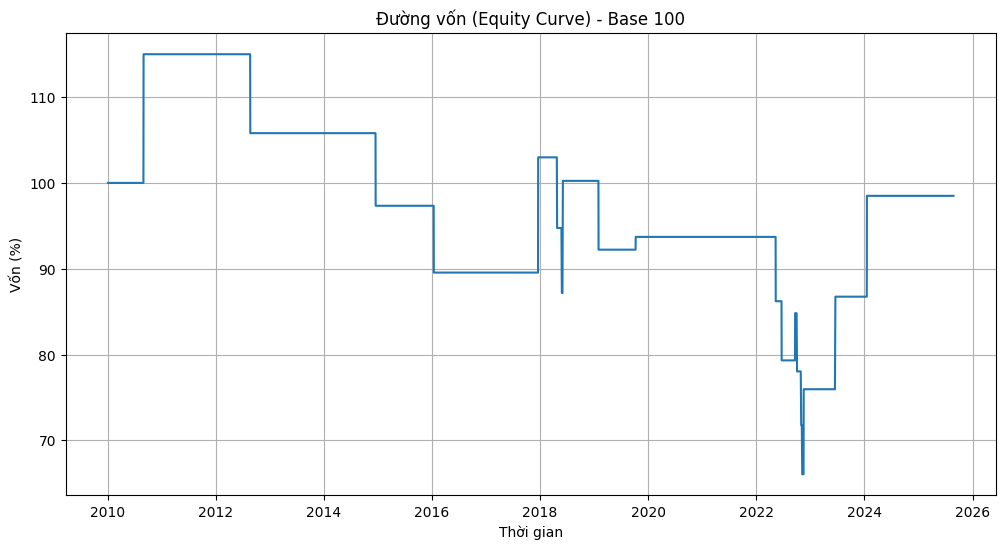

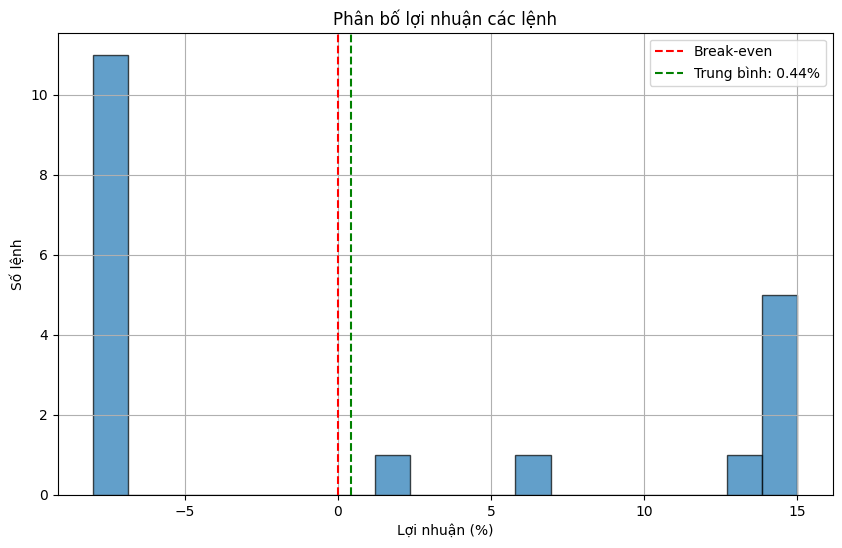


--- HIỆU SUẤT THEO NĂM (HPG) ---
      Số lệnh  Lợi nhuận trung bình  Lợi nhuận tổng
year                                               
2010        1                 15.00           15.00
2012        1                 -8.00           -8.00
2014        1                 -8.00           -8.00
2015        1                 -8.00           -8.00
2017        1                 15.00           15.00
2018        4                 -2.25           -9.00
2019        1                  1.62            1.62
2022        7                 -2.58          -18.06
2023        2                 13.88           27.75


(   entry_date  exit_date  entry_price  exit_price    exit_reason  hold_days  \
 0  2010-08-13 2010-09-01         1.25        1.46    TAKE_PROFIT         19   
 1  2012-07-12 2012-08-22         0.97        0.89      STOP_LOSS         41   
 2  2014-10-28 2014-12-17         3.51        3.10      STOP_LOSS         50   
 3  2015-12-11 2016-01-14         2.97        2.64      STOP_LOSS         34   
 4  2017-11-14 2017-12-19         7.09        8.26    TAKE_PROFIT         35   
 5  2018-04-20 2018-04-26        11.14       10.14      STOP_LOSS          6   
 6  2018-05-18 2018-05-28        10.21        9.23      STOP_LOSS         10   
 7  2018-05-29 2018-06-04         9.85       11.37    TAKE_PROFIT          6   
 8  2018-12-24 2019-01-31         8.09        7.35      STOP_LOSS         38   
 9  2019-07-11 2019-10-09         7.43        7.55  MAX_HOLD_DAYS         90   
 10 2022-04-20 2022-05-12        24.77       21.93      STOP_LOSS         22   
 11 2022-06-16 2022-06-21        17.77  

In [37]:
run_macd_backtest_for_symbol(
    'HPG',
    data_all=data_all,
    window=40,
    initial_capital=100_000_000,
    stop_loss_pct=-0.08,
    take_profit_pct=0.15,
    max_hold_days=90
)

In [38]:
def run_macd_backtest_for_symbol_no_print(symbol, data_all=data_all, window=40, initial_capital=100_000_000, stop_loss_pct=-0.10, take_profit_pct=0.30, max_hold_days=90):
    """
    Chạy toàn bộ quy trình MACD divergence + backtest cho 1 mã cổ phiếu, KHÔNG in ra kết quả.
    """
    df_symbol = filter_data_by_symbol(symbol, data_all)
    bullish, bearish, df_res, hist_ext = find_macd_divergence(df_symbol, window=window)
    bullish = bullish[~bullish.index.duplicated(keep='first')]
    bearish = bearish[~bearish.index.duplicated(keep='first')]
    results_df, equity_curve, metrics = backtest_divergence_strategy(
        df=df_symbol,
        bullish_signals=bullish,
        initial_capital=initial_capital,
        stop_loss_pct=stop_loss_pct,
        take_profit_pct=take_profit_pct,
        max_hold_days=max_hold_days
    )
    # KHÔNG gọi analyze_backtest_results
    if not results_df.empty:
        results_df['year'] = results_df['entry_date'].dt.year
    return results_df, equity_curve, metrics

In [39]:

# --- CHẠY BACKTEST CHO TOÀN BỘ VN30, KHÔNG IN RA CHI TIẾT TỪNG MÃ ---
vn30_symbols = get_symbols_by_group("VN30")
all_results = []

for symbol in vn30_symbols:
    # print(f"Đang chạy backtest cho {symbol} ...")
    try:
        results_df, equity_curve, metrics = run_macd_backtest_for_symbol_no_print(
            symbol, data_all=data_all, window=40, 
            initial_capital=100_000_000, stop_loss_pct=-0.08, 
            take_profit_pct=0.15, max_hold_days=90
        )
        if not results_df.empty:
            results_df['symbol'] = symbol
            all_results.append(results_df)
    except Exception as e:
        print(f"Lỗi với mã {symbol}: {e}")

if all_results:
    all_trades_df = pd.concat(all_results, ignore_index=True)
    print("\n========== THỐNG KÊ MÔ TẢ TOÀN BỘ LỢI NHUẬN CÁC LỆNH VN30 ==========")
    print(all_trades_df['pnl_pct'].describe(percentiles=[.25, .5, .75]) * 100)
    print(f"\nLợi nhuận trung bình toàn bộ lệnh: {all_trades_df['pnl_pct'].mean() * 100:.2f}%")
    print(f"Tổng số lệnh: {len(all_trades_df)}")
else:
    print("Không có lệnh nào được thực hiện cho các mã VN30.")


========== THỐNG KÊ MÔ TẢ TOÀN BỘ LỢI NHUẬN CÁC LỆNH VN30 ==========
count    43900.000000
mean         1.455721
std          9.802647
min         -8.000000
25%         -8.000000
50%         -1.579280
75%         15.000000
max         15.000000
Name: pnl_pct, dtype: float64

Lợi nhuận trung bình toàn bộ lệnh: 1.46%
Tổng số lệnh: 439
